BẮT ĐẦU CHẠY: ZDT1
• Cấu hình: Obj=2 | Var=30 | Pop=300 | Gen=300
Thời gian chạy: 13.0988 giây
  >> IGD Final: 0.001352
  >> HV  Final: 0.874647


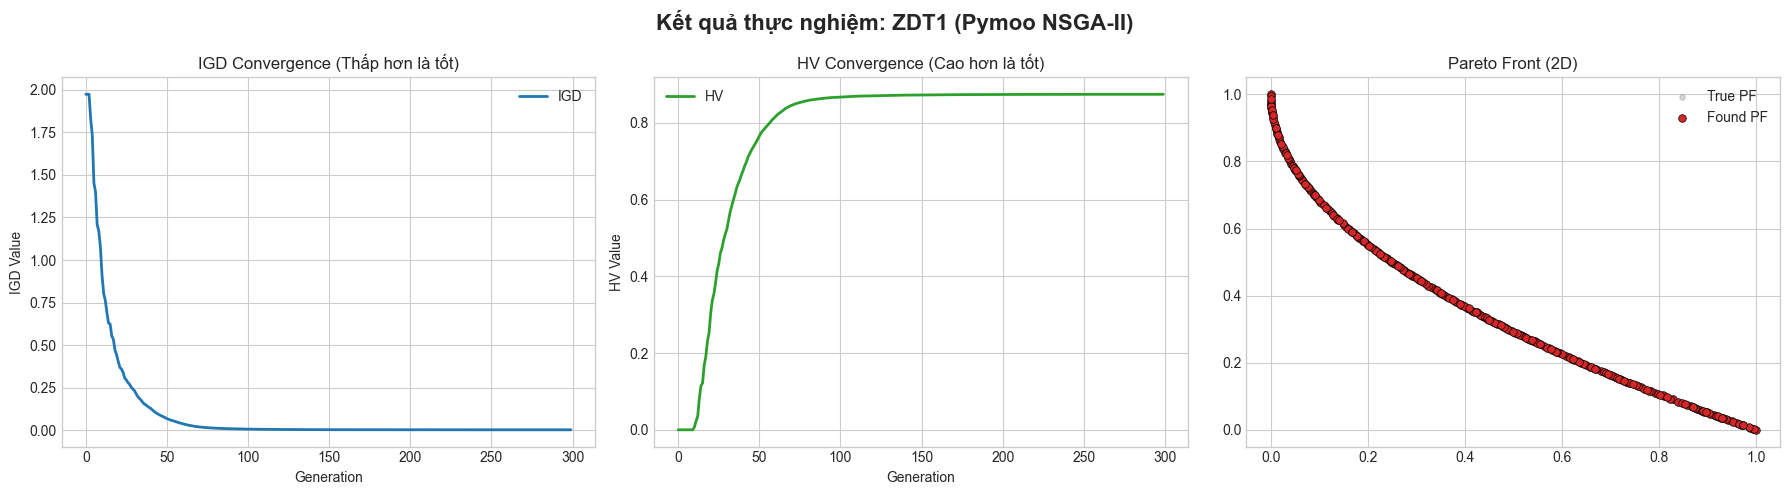

BẮT ĐẦU CHẠY: ZDT2
• Cấu hình: Obj=2 | Var=30 | Pop=300 | Gen=300
Thời gian chạy: 25.4508 giây
  >> IGD Final: 0.001431
  >> HV  Final: 0.541441


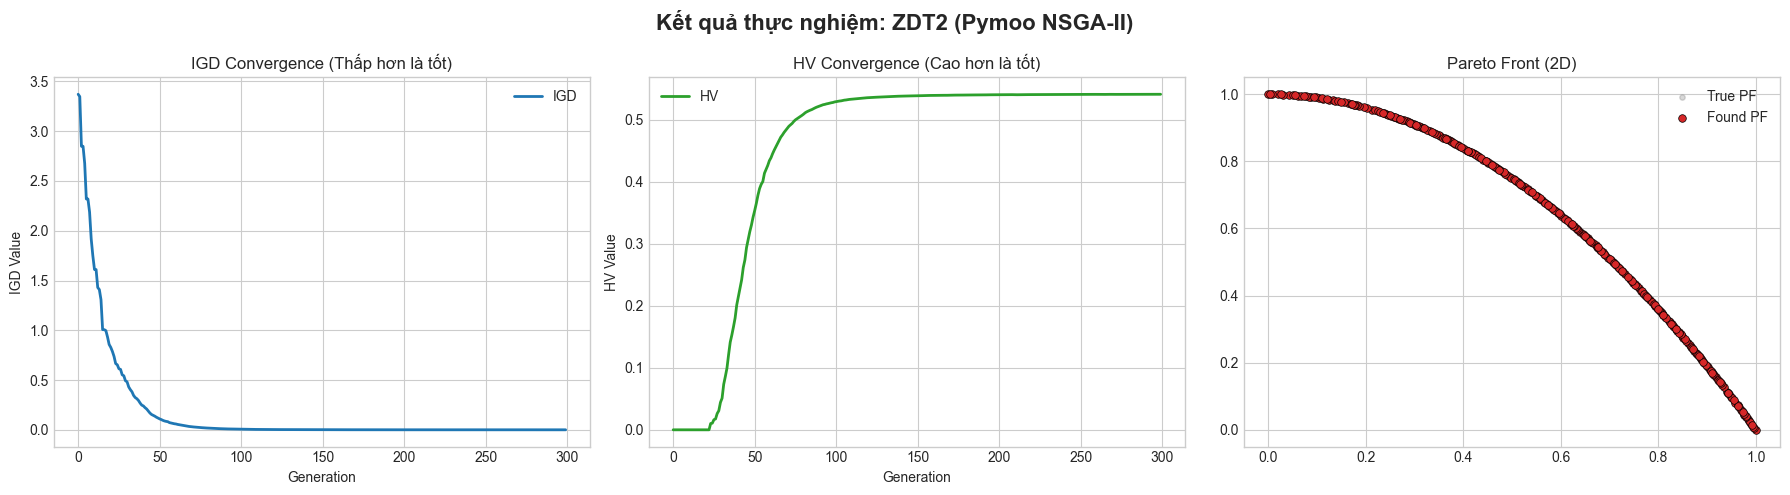

BẮT ĐẦU CHẠY: ZDT3
• Cấu hình: Obj=2 | Var=30 | Pop=300 | Gen=300
Thời gian chạy: 22.9137 giây
  >> IGD Final: 0.001559
  >> HV  Final: 1.025418


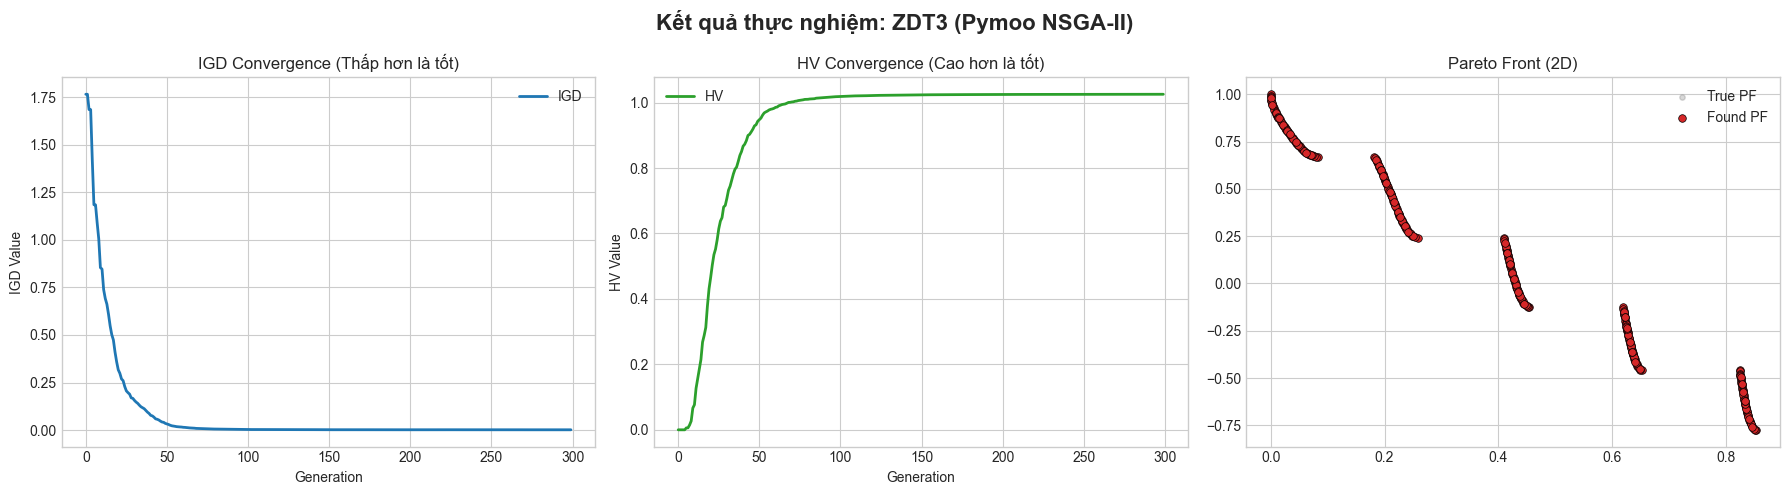

BẮT ĐẦU CHẠY: ZDT4
• Cấu hình: Obj=2 | Var=10 | Pop=300 | Gen=300
Thời gian chạy: 16.6187 giây
  >> IGD Final: 0.001447
  >> HV  Final: 0.874499


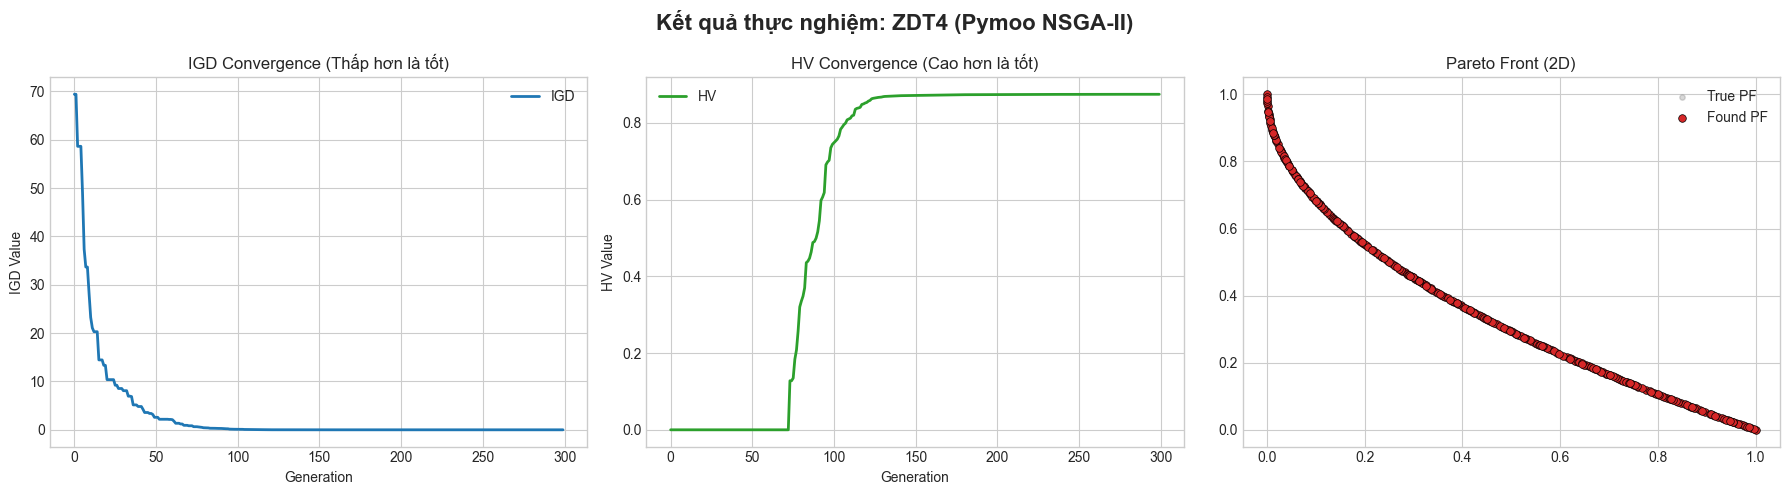

BẮT ĐẦU CHẠY: ZDT6
• Cấu hình: Obj=2 | Var=10 | Pop=300 | Gen=300
Thời gian chạy: 11.0857 giây
  >> IGD Final: 0.002032
  >> HV  Final: 0.433622


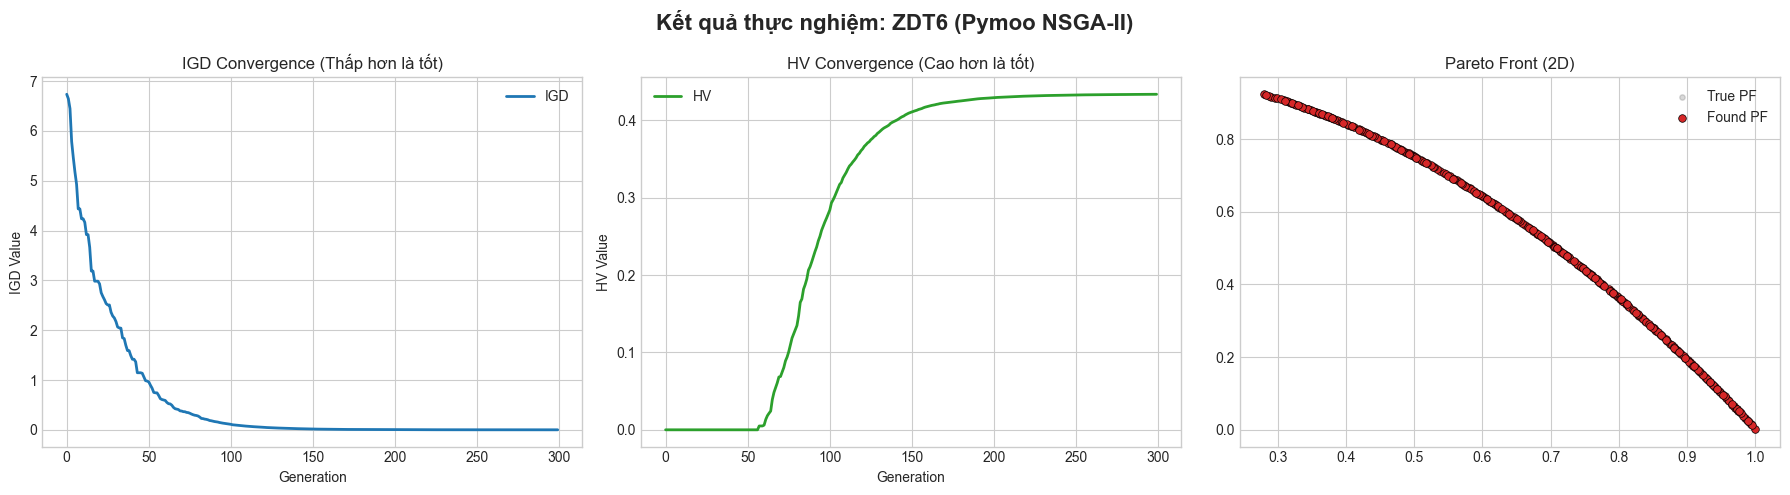



                                KẾT QUẢ TỔNG HỢP                                
╒═══════════╤═══════════════╤═════════╤═════════╤════════╤════════╤════════════╕
│ Problem   │ Algorithm     │   n_Var │   n_Obj │    IGD │     HV │   Time (s) │
╞═══════════╪═══════════════╪═════════╪═════════╪════════╪════════╪════════════╡
│ ZDT1      │ Pymoo NSGA-II │      30 │       2 │ 0.0014 │ 0.8746 │    13.0988 │
├───────────┼───────────────┼─────────┼─────────┼────────┼────────┼────────────┤
│ ZDT2      │ Pymoo NSGA-II │      30 │       2 │ 0.0014 │ 0.5414 │    25.4508 │
├───────────┼───────────────┼─────────┼─────────┼────────┼────────┼────────────┤
│ ZDT3      │ Pymoo NSGA-II │      30 │       2 │ 0.0016 │ 1.0254 │    22.9137 │
├───────────┼───────────────┼─────────┼─────────┼────────┼────────┼────────────┤
│ ZDT4      │ Pymoo NSGA-II │      10 │       2 │ 0.0014 │ 0.8745 │    16.6187 │
├───────────┼───────────────┼─────────┼─────────┼────────┼────────┼────────────┤
│ ZDT6      │ Pymoo NSGA-I

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.indicators.igd import IGD
from pymoo.indicators.hv import HV
from pymoo.termination import get_termination

# Cấu hình giao diện biểu đồ
plt.style.use('seaborn-v0_8-whitegrid')

def run_experiment_pymoo(problem_name, n_gen=100, pop_size=100, seed=42, n_var=None, n_obj=None):
    # 1. Cấu hình bài toán
    p_name_upper = problem_name.upper()
    print(f"BẮT ĐẦU CHẠY: {p_name_upper}")
    
    # Lấy đối tượng bài toán từ pymoo
    if 'dtlz' in problem_name.lower():
        pymoo_prob = get_problem(problem_name, n_var=n_var, n_obj=n_obj)
        is_3d = True
    else: # ZDT problems
        pymoo_prob = get_problem(problem_name, n_var=n_var)
        n_obj = pymoo_prob.n_obj
        is_3d = False

    print(f"• Cấu hình: Obj={n_obj} | Var={n_var} | Pop={pop_size} | Gen={n_gen}")
    algorithm = NSGA2(
        pop_size=pop_size,
        eliminate_duplicates=True
    )

    termination = get_termination("n_gen", n_gen)

    start_time = time.time()
    
    res = minimize(
        pymoo_prob,
        algorithm,
        termination,
        seed=seed,
        save_history=True,
        verbose=False
    )
    
    end_time = time.time()
    run_time = end_time - start_time
    print(f"Thời gian chạy: {run_time:.4f} giây")

    true_pf = pymoo_prob.pareto_front()

    final_front = res.F

    if true_pf is not None:
        ref_point = np.max(true_pf, axis=0) * 1.1
    else:
        ref_point = np.max(final_front, axis=0) * 1.1
    igd_indicator = IGD(true_pf) if true_pf is not None else None
    hv_indicator = HV(ref_point=ref_point)

    igd_history = []
    hv_history = []

    # Duyệt qua lịch sử để tính chỉ số cho từng thế hệ
    if len(res.history) > 0:
        for algorithm_step in res.history:
            # Lấy mục tiêu (F) của quần thể tại thế hệ đó
            pop_F = algorithm_step.pop.get("F")
            
            # Tính IGD
            if igd_indicator:
                igd_history.append(igd_indicator(pop_F))
            else:
                igd_history.append(0)
            
            # Tính HV
            try:
                hv_history.append(hv_indicator(pop_F))
            except:
                hv_history.append(0)
    else:
        # Fallback nếu không lưu history
        igd_history = [0] * n_gen
        hv_history = [0] * n_gen

    final_igd = igd_history[-1] if igd_history else 0.0
    final_hv = hv_history[-1] if hv_history else 0.0

    print(f"  >> IGD Final: {final_igd:.6f}")
    print(f"  >> HV  Final: {final_hv:.6f}")

    # 5. Vẽ biểu đồ (Theo phong cách yêu cầu)
    fig = plt.figure(figsize=(18, 5))
    fig.suptitle(f'Kết quả thực nghiệm: {p_name_upper} (Pymoo NSGA-II)', fontsize=16, fontweight='bold')

    # Subplot 1: IGD
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.plot(igd_history, color='#1f77b4', linewidth=2, label='IGD')
    ax1.set_title('IGD Convergence (Thấp hơn là tốt)', fontsize=12)
    ax1.set_xlabel('Generation')
    ax1.set_ylabel('IGD Value')
    ax1.legend()

    # Subplot 2: HV
    ax2 = fig.add_subplot(1, 3, 2)
    ax2.plot(hv_history, color='#2ca02c', linewidth=2, label='HV')
    ax2.set_title('HV Convergence (Cao hơn là tốt)', fontsize=12)
    ax2.set_xlabel('Generation')
    ax2.set_ylabel('HV Value')
    ax2.legend()

    # Subplot 3: Pareto Front
    if is_3d:
        ax3 = fig.add_subplot(1, 3, 3, projection='3d')
        if true_pf is not None:
            ax3.scatter(true_pf[:, 0], true_pf[:, 1], true_pf[:, 2], c='grey', alpha=0.1, s=10, label='True PF')
        ax3.scatter(final_front[:, 0], final_front[:, 1], final_front[:, 2], c='#d62728', s=30, label='Found PF', edgecolors='black', linewidth=0.5)
        ax3.set_title('Pareto Front (3D)', fontsize=12)
        ax3.view_init(elev=30, azim=45)
    else:
        ax3 = fig.add_subplot(1, 3, 3)
        if true_pf is not None:
            ax3.scatter(true_pf[:, 0], true_pf[:, 1], c='grey', alpha=0.3, s=15, label='True PF')
        ax3.scatter(final_front[:, 0], final_front[:, 1], c='#d62728', s=30, label='Found PF', edgecolors='black', linewidth=0.5)
        ax3.set_title('Pareto Front (2D)', fontsize=12)
    
    ax3.legend()
    plt.tight_layout()
    plt.show()

    return {
        "Problem": p_name_upper,
        "Algorithm": "Pymoo NSGA-II",
        "n_Var": n_var,
        "n_Obj": n_obj,
        "IGD": final_igd,
        "HV": final_hv,
        "Time (s)": run_time
    }

# --- CẤU HÌNH CHẠY ---
POP_SIZE = 300 
N_GEN = 300     
problems_list = ['zdt1', 'zdt2', 'zdt3', 'zdt4', 'zdt6']

results = []

for p_name in problems_list:
    if 'dtlz' in p_name:
        n_obj = 3
        k_mapping = {"dtlz1": 5, "dtlz7": 20} 
        k = k_mapping.get(p_name, 10)
        n_var = n_obj + k - 1
    elif 'zdt' in p_name:
        n_obj = 2
        if any(x in p_name for x in ['zdt1', 'zdt2', 'zdt3']): 
            n_var = 30
        elif any(x in p_name for x in ['zdt4', 'zdt6']): 
            n_var = 10
        else: 
            n_var = 30

    res = run_experiment_pymoo(
        problem_name=p_name,
        n_gen=N_GEN,
        pop_size=POP_SIZE,
        seed=1,
        n_var=n_var,
        n_obj=n_obj
    )
    results.append(res)
df = pd.DataFrame(results)
print("\n")
print("KẾT QUẢ TỔNG HỢP".center(80))
print(tabulate(df, headers='keys', tablefmt='fancy_grid', floatfmt=".4f", showindex=False))